# 0.Assignments

👾 這個陽春的聊天機器人需要被優化！<br>
若是一個對話串不間斷地持續進行，送進去的訊息量會很多，tokens數量也會跟著增加，會需要花比較多費用(💸💸💸)，也可能使模型的回應雜訊比較多而回應受到干擾，所以我們可以優化短期記憶。<br>
另外，我們希望優化使用者體驗，我們可以根據聊天的內容整理出使用者的屬性，並在每一次跟使用者聊天時，都能根據這個使用者的狀況給予客製化的回應，因此我們要加入長期記憶的功能！

<br>

### 1. 短期記憶優化

(1) 🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)


<br>

### 2. 加入長期記憶

加入長期記憶，讓聊天機器人能夠記住使用者的資訊（名字、偏好語言、興趣），在下一次對話也能針對同個使用者的資訊，給予個人化的回答。

(1) 🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>


(2) 👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)
<br>
備註：基本版是需要大家完成的，進階版可以自行決定是否挑戰，Enjoy the ride! 😎

# 1.短期記憶

## (1) 基本版
🔰 [基本版] 在短期記憶中，將chatbot node送入llm的訊息中加入trim的優化機制 (依據適當的tokens數量決定)

note: 可以邊做邊看一下trim設定的效果以及內部運作的機制

In [1]:
from langchain_openai import ChatOpenAI

# Models
chat_llm = ChatOpenAI(
    openai_api_key="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",
    openai_api_base="https://openrouter.ai/api/v1",
    model_name="mistralai/mistral-small-3.1-24b-instruct:free",
    temperature=0.1
)

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, trim_messages
from langchain_core.messages.utils import count_tokens_approximately
from langchain_core.prompts import ChatPromptTemplate

from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State):
  trimmed_messages = trim_messages(
    state["messages"],
    max_tokens=2000,
    strategy="last",
    token_counter=count_tokens_approximately,
    start_on="human",
    include_system=True,
    allow_partial=False,
  )

  prompt_template = ChatPromptTemplate([
    ("system", "你是萬能的百科全書，能夠以自身的知識回答使用者問題"),
    ("placeholder", "{messages}"),
  ])
  chat_chain = prompt_template | chat_llm
  response = chat_chain.invoke({"messages": trimmed_messages})
  return {"messages": [response]}


# 建立graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入短期記憶
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


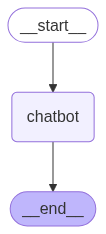

In [3]:
# 看一下graph
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [4]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
      if "chatbot" in event:
        for value in event.values():
          print("Assistant:", value["messages"][-1].content)

In [5]:
# 設定對話config (第一次對話)
config = {"configurable": {"thread_id": "conversation_1"}} # thread_id: 對話id

In [6]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

Assistant: 你好！有什麼我可以幫忙的嗎？無論是學習、工作、生活中的問題，還是其他你感興趣的話題，我都很樂意提供幫助。請隨時告訴我你需要什麼資訊或建議。
Assistant: 蘋果公司（Apple Inc.）以其創新能力和產品設計而聞名，歷史上已經推出了許多革命性的產品。未來，蘋果可能會在以下幾個領域進行創新和發明：

1. **增強現實（AR）和虛擬現實（VR）**：
   - **AR眼鏡**：蘋果可能會推出自己的AR眼鏡，這些眼鏡可以用於遊戲、教育、醫療等多個領域。
   - **VR頭戴設備**：雖然蘋果目前沒有推出VR頭戴設備，但這是一個潛在的發展方向。

2. **健康與健身**：
   - **Apple Watch**：蘋果可能會繼續改進Apple Watch，增加更多的健康監測功能，如血糖監測、心臟健康等。
   - **健康應用**：開發更多的健康應用，幫助用戶管理自己的健康狀況。

3. **自動駕駛汽車**：
   - **Apple Car**：雖然蘋果的自動駕駛汽車項目（Project Titan）經歷了多次變動，但這仍然是一個潛在的發展方向。

4. **人工智能（AI）和機器學習**：
   - **Siri**：進一步改進Siri，使其更加智能和個性化。
   - **AI應用**：開發更多基於AI的應用，如智能家居控制、個性化推薦等。

5. **可穿戴設備**：
   - **新型可穿戴設備**：除了Apple Watch，蘋果可能會推出其他形式的可穿戴設備，如智能手環、智能服裝等。

6. **環保技術**：
   - **可持續能源**：開發更多環保技術，如太陽能充電、可回收材料等，減少對環境的影響。

7. **教育技術**：
   - **教育平台**：開發更多教育應用和平台，幫助學生和教師更好地學習和教學。

8. **家庭娛樂**：
   - **Apple TV**：進一步改進Apple TV，增加更多的內容和功能，如遊戲、流媒體服務等。

這些只是一些可能的發展方向，蘋果公司的創新能力和市場洞察力使得它在未來可能會推出更多令人驚喜的產品和技術。
Assistant: 蘋果（Apple）和三星（Samsung）都是全球領先的科技公司，各自有其獨特的產品和創新。最近，兩家公司都推出了許多有趣的產品，以下是一些

---

# 2.長期記憶

## (1) 基本版
🔰 [基本版]
- chatbot node: 在chatbot node中，將該使用者的資訊取出，讓入prompt中讓llm依據使用者的資訊給予個人化的回答

- write_memory node: 在每一次生成回答後，將使用者的資訊整理成一段對使用者的描述(使用llm，給予system prompt做指引，自行設計如何整理、需要整理哪些資訊)，將整理完的資訊整理到store (可跨threads存取的地方)。

- config: config從原本的短期記憶只有thread_id, 也要加入user_id

<img src="https://drive.google.com/uc?export=view&id=1H4Y0WplOi6R4Eo06Ac2JA_9TbZa2YaRD" width="100"/>

In [ ]:
import uuid
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver # within-thread memory
from langgraph.store.memory import InMemoryStore # cross-thread store
from langgraph.store.memory import BaseStore

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State, config: RunnableConfig, store: BaseStore):
  user_id = config["configurable"]["user_id"]

  # long-term memory
  memories = store.search(user_id)
  user_profile = ""
  if memories:
    memories = "\n".join([d.value["memory"] for d in memories])
    user_profile = (
      f"，回答時可參考以下使用者提供的相關資訊，依據用戶的偏好去調整本次回答\n"
      f"**user_profile**\n{memories}"
    )
    print(memories)

  # llm response
  prompt_template = ChatPromptTemplate([
    ("system", "你是萬能的百科全書，能夠以自身的知識回答使用者問題{user_profile}"),
    ("placeholder", "{messages}"),
  ])
  chat_chain = prompt_template | chat_llm
  response = chat_chain.invoke({"messages": state["messages"], "user_profile": user_profile})
  return {"messages": [response]}


def write_memory(state: State, config: RunnableConfig, store: BaseStore):
  user_id = config["configurable"]["user_id"]
  memory_id = str(uuid.uuid4())

  messages = "\n".join([f"{msg.type}: {msg.content}" for msg in state["messages"]])
  prompt_template = ChatPromptTemplate([
    ("system", f"請根據使用者與聊天機器人間的對話紀錄，整理出30字內的用戶特徵，只回傳摘要後內容即可。\n範例: 使用者是男生，喜歡上網看 Youtube"),
    ("human", "**對話紀錄**\n{messages}"),
  ])
  memory_chain = prompt_template | chat_llm
  response = memory_chain.invoke({"messages": messages})

  store.put(user_id, memory_id, {"memory": response.content})


# Models
chat_llm = ChatOpenAI(
    openai_api_key="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",
    openai_api_base="https://openrouter.ai/api/v1",
    model_name="mistralai/mistral-small-3.1-24b-instruct:free",
    temperature=0.1
)

# Define the graph
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", "write_memory")
builder.add_edge("write_memory", END)

checkpointer = MemorySaver()
memory_store = InMemoryStore()
graph = builder.compile(checkpointer=checkpointer, store=memory_store)


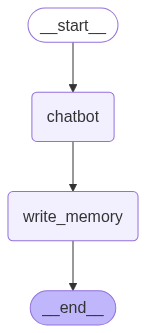

In [3]:
# View
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [4]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
              print("Assistant:", value["messages"][-1].content)

In [24]:
# 使用者A的第一次對話
config = {"configurable": {"thread_id": "conversation_1", "user_id": "user_a"}}

In [49]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

Assistant: 開始學習Python可以從以下幾個步驟開始：

1. **安裝Python**：從[Python官方網站](https://www.python.org/)下載並安裝最新版本的Python。

2. **選擇編輯器**：使用像是VS Code、PyCharm或Jupyter Notebook等編輯器來撰寫和測試你的Python程式碼。

3. **學習基礎語法**：從基本的語法開始，如變數、資料型態、控制結構（如if-else、for、while）和函數。

4. **練習小項目**：從簡單的小項目開始，如計算器、猜數字遊戲或簡單的網頁爬蟲。

5. **參考資源**：使用在線教程、書籍或視頻課程，如Codeacademy、Coursera或YouTube上的Python教學影片。

6. **參與社群**：加入Python社群，如Stack Overflow、Reddit的r/learnpython或本地的Python使用者群組，與其他學習者和專家交流。

7. **持續學習**：隨著時間的推移，逐步學習更高級的主題，如物件導向編程、資料庫操作、網頁開發等。

希望這些建議能幫助你開始你的Python學習之旅！
Assistant: 當然有！以下是一些非常受歡迎且適合初學者的Python教學YouTube頻道和影片：

1. **Corey Schafer**
   - **頻道連結**: [Corey Schafer](https://www.youtube.com/user/schafer5)
   - **推薦影片**: "Python Tutorial for Beginners" 系列，這系列影片從基本概念開始，逐步深入，非常適合初學者。

2. **Tech With Tim**
   - **頻道連結**: [Tech With Tim](https://www.youtube.com/c/TechWithTim)
   - **推薦影片**: "Python Full Course for Beginners"，這是一個完整的Python入門課程，涵蓋了從基本語法到進階主題的內容。

3. **freeCodeCamp.org**
   - **頻道連結**: [freeCodeCamp.org](https://www.yo

In [ ]:
a = [
    '我喜歡寫python 但不知道怎麼開始，簡短回答',
    '有推薦的Youtube影片嗎？',
    '我只有windows電腦，其他大學同學在學習的時候都是用mac，我是不是也要買？'
]

In [50]:
# 使用者A的第二次對話
config = {"configurable": {"thread_id": "conversation_2", "user_id": "user_a"}}

In [51]:
# 開始對話 (可以輸入quit, exit, q，三選一停止對話)
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config)
  except Exception as e:
    print(e)
    break

Assistant: 作為一名Python初學者，你有很多選擇可以開始寫程式。以下是一些適合初學者的Python程式範例，這些範例可以幫助你逐步提升編程技能：

1. **簡單的計算器**：
   - 這個程式可以執行基本的算術運算，如加法、減法、乘法和除法。這將幫助你熟悉基本的輸入輸出和控制結構。

2. **猜數字遊戲**：
   - 這個程式會隨機生成一個數字，讓使用者猜測。根據使用者的猜測，程式會給出提示，告訴使用者猜的數字是太大還是太小。這將幫助你了解條件判斷和迴圈。

3. **待辦事項清單**：
   - 這個程式可以讓使用者添加、刪除和查看待辦事項。這將幫助你了解列表和字典的使用。

4. **簡單的網頁爬蟲**：
   - 使用`requests`和`BeautifulSoup`庫，你可以撰寫一個簡單的網頁爬蟲，從網頁上抓取資料。這將幫助你了解如何與網路資源互動。

5. **簡單的資料分析**：
   - 使用`pandas`庫，你可以撰寫一個簡單的資料分析程式，讀取CSV檔案並進行基本的資料處理和分析。這將幫助你了解資料處理和分析的基本概念。

6. **簡單的圖形化介面（GUI）**：
   - 使用`tkinter`庫，你可以撰寫一個簡單的圖形化介面程式。這將幫助你了解如何設計和實現圖形化介面。

7. **簡單的遊戲**：
   - 例如，撰寫一個簡單的蛇遊戲或跳躍遊戲。這將幫助你了解遊戲開發的基本概念，如物件導向編程和事件處理。

這些範例都可以在YouTube上找到相關的教學影片，幫助你更好地理解和實現這些程式。你也可以參考一些Python的在線教程和書籍，進一步深入學習。
Assistant: 根據你提供的資訊，以下是你的偏好和特徵：

1. **喜歡寫程式**：
   - 你對編寫程式有濃厚的興趣，這是你學習Python的主要動力。

2. **學習Python**：
   - 你正在學習Python，這表明你對這門程式語言有興趣，並希望通過它來實現你的編程目標。

3. **喜歡網路資源**：
   - 你喜歡使用網路資源來學習和獲取資訊，這表明你善於利用互聯網來提升自己的技能。

4. **使用YouTube學習**：
   - 你喜歡通過YouTube來學習Python，這表明你更傾向於視覺和聽覺的學習方式。

5. **使

## (2) 進階版

👨‍🎓 [進階版]
- chatbot node: 可以決定使用者的問題是否需要從長期記憶中取得資訊，以及需要取得什麼資訊
- write_memory node: 可以整理成特定格式 (例如：使用with_structured_output，相關概念可以延伸到R3 tool calling內容)。例如：
```
user_profile = {
  "first_name": "XXXX",
  "last_name": "OOO",
  "preferred_lang": ["en", "zh-tw"]
}
```
- 也可以自行將graph結構調整自己喜歡的(增刪不同node, conditional router, ...)

In [ ]:
# 💻code here, enjoy the ride 😎
